# Volume Response Model Multiple Market Makers - via Pontryagin

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models a multiple market makers and solves the resulting game by an iterative scheme based on the Pontryagin optimality principle.

## Problem formulation

### Dynamics

We will have $i=1,\ldots,N$ market makers.
Each market maker uses two controls: $\theta^i_t = \left[\alpha^{i,f}_t, \alpha^{i,S}_t \right]$ which fix the speed of change in their desired fee and stake respectively: 
$$
df^i_t = \alpha^{i,f}_t dt
$$
and
$$
dS^i_t = \alpha^{i,S}_t dt\,.
$$
The trading volume in the market evolves as
$$ dV_t = \kappa_D \left( \text{LD}_F^{\ast} - \frac{V_t}{ \bar S_t} \right)V_t dt - \kappa_f L(\bar f_t) V_t dt, \quad V_0 = v_0\,,$$
where $\bar S_t = \sum_{i=1}^N S^i_t$ and where
$$
L(f) = \frac{1}{1 + \exp(-(f-\text{FP}^{\text{mid}}))}
$$
is a logistic function determining the fee level from $\bar f_t$.



Let us now look at how $\bar f_t$ is calculated. First we sort $f^i_t$ from smallest to largest: 
$$f^{\pi(1)}_t \leq f^{\pi(2)}_t \leq \cdots \leq f^{\pi(N)}_t\,.$$
We calculate the cumulative stake corresponding to market makers providing fees, sorted from smallest to largest:
$$
C^i_t := \sum_{j=1}^i S^{\pi(j)}_t\,. 
$$
We check the index of the last market maker providing commitment needed to meet current liquidity demand:
$$
i^\ast := \max\left\{ i = 1,\ldots,N : \kappa_C C^i \leq \frac{V_t}{\bar S_t} \right\} \,.
$$
Finally we set 
$$
\bar f_t := \sum_{j=1}^{i^\ast + 1} f^{\pi(i)}_t \frac{S^{\pi(i)}_t}{C^{i^\ast+1}}
$$

### Optimization problem, Nash equilibrium

The optimization criteria for market maker / agent $i$ is to maximize
$$
J^i(\theta^{-i,f},\theta^i) = \int_0^T \left( L(\bar f_t^\theta) V_t^\theta  \frac{S^i_t}{\bar S_t^\theta} - \gamma^i S^i_t\right)\,dt
$$

We are hoping to find the Nash equilibrium i.e. strategies $\hat \theta$ such that for any $i$ taking some other $\theta^i$ satisfies 
$$
J^i(\hat \theta^{-i}, \hat \theta^i) \geq J^i(\hat \theta^{-i}, \theta^i)\,.
$$

$$ dX^i_t = b\left(\mathbf{X}^i,\mathbf{\theta^i}\right)dt$$
where

$$\mathbf{X}_t = \left[ V_t, f_t, S_t \right], \quad  \mathbf{\theta}_t = \left[ \alpha^f_t, \alpha^S_t \right] $$

and
$$ dV_t = \kappa_D \left( \text{LD}_F^{\ast} - \frac{V_t}{\kappa_S S_t} \right)V_t dt - \kappa_f\frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))}V_t dt, \quad V_0 = v_0$$ 

where:

* $V_t \text{ denotes trading volume at time } t,$
* $S_t \text{ denotes stake level at time } t,$
* $f_t \text{ denotes fee level at time } t,$
* $LD_F^{\ast} \text{ denotes liquidity demand mean-reversion level and corresponds to parameter } \verb|liq_dem_F_star| \text{ in the code}$,
* $\text{FP}^{\text{mid}} = \verb|fee_param_mid| $




$$ $$

$$b\left(\mathbf{X},\mathbf{\theta}\right) = \begin{bmatrix}
\kappa_D \left( \text{LD}_F^{\ast} - \frac{V}{\kappa_S S} \right)V - \kappa_f\frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))}V \\
\alpha^f \\
\alpha^S \\
\end{bmatrix}$$

Maximise: 
$$ J\left(\alpha^f, \alpha^S \right) = \int_0^T F\left(\mathbf{X}_t, \mathbf{\theta}_t \right) dt$$
where
$$F\left(\mathbf{X}_t, \mathbf{\theta}_t \right) := \frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))} V_t - \gamma S_t-\frac{\delta_f}{2}(\alpha_t^f)^2-\frac{\delta_S}{2}(\alpha_t^S)^2$$

Let:

$$H(\mathbf{X}_t, \mathbf{\theta}_t, p) = b\left(\mathbf{X}_t,\mathbf{\theta}_t\right) \cdot p + F\left(\mathbf{X}_t, \mathbf{\theta}_t \right)$$



In [1]:
import math, sys 
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Number of agents
N_agents = 3

# global parameters
T = 1.2
kappa_D = 1.0
kappa_f = 2.0
kappa_S = 1.0
kappa_C = 0.01
fee_param_mid = 10.0
liq_dem_F_star = 1.6
initial_volume = 100

# agent dependent parameters
gamma = [0.04, 0.03, 0.02]; # cost of capital
delta_f = 1e-2*np.ones(N_agents) # penalty for fee change, I don't see why this would ever be different across agents
delta_S = 1e-15*np.ones(N_agents) # penalty for stake change, this could differ across agents as some may be able to access capital faster

# agent dependent initial conditions
initial_fee_sliders = [0.0, 0.0, 0.0]
initial_stakes = [75, 50, 25]

# Parameter for approximating partial derivatives
fd_delta = 1e-6

# Time discretization
N_T = 40
delta_t = T / (N_T-1)

# 0 is volume
# 1,...,N fees sliders for agents 1,...,N
# N+1,...,2N stakes for agents 1,...,N
x_vals = np.zeros([2*N_agents+1,N_T+1])
x_vals[0,0] = initial_volume
x_vals[1:(N_agents+1),0] = initial_fee_sliders
x_vals[(N_agents+1):(2*N_agents)+1,0] = initial_stakes

# thetas[0:(N-1),:] controls fee sliders, thetas[N:(2*N-1),:] controls the stakes
thetas = np.zeros([2*N_agents,N_T+1])

In [3]:
betas_vol = [0.5, 0.5, 0.5, 0.5]
betas_cash = [0.2, 0.2, 0.2, 0.1]

def terminal_volume_utility(volume,agt_idx):
    beta = betas_vol[agt_idx]
    return 0.002*np.power(volume,beta) # power utility; same for everyone

def gain_utility(x,agt_idx):
    beta = betas_cash[agt_idx]
    return (1.0 - np.exp(-x*beta))/beta
    return x
    

In [4]:
def fee_param_logistic(f):
    min_fee = 0.001
    max_fee = 3.0-min_fee
    return min_fee + max_fee/(1.0+np.exp(-0.1*(f-fee_param_mid)))

def fee_slider_from_fee_sliders_and_stakes(x):
    volume = x[0]
    fee_sliders = x[1:(N_agents+1)]
    stakes = x[(N_agents+1):(2*N_agents+1)]
    
    assert sum(stakes)>0 , "All stakes zero, not good."
    total = sum(stakes)
    fee_slider_bar = (1.0/total)*np.dot(fee_sliders,stakes)
    #print(fee_slider_bar)
    return fee_slider_bar

In [5]:
N_agents = 3
x_test = np.zeros(2*N_agents+1)
volume = 1000
x_test[0] = volume
fees_sliders = [-200.0, -10.0, -10.0]
x_test[1:(N_agents+1)] = fees_sliders
stakes = [10,20,30]
x_test[(N_agents+1):2*(N_agents+1)] = stakes
print(x_test)
LD = volume/sum(stakes)
print("Liquidity demand %f" % LD)
fee_slider_bar = fee_slider_from_fee_sliders_and_stakes(x_test)
print("Fee slider %f" % fee_slider_bar)
print("Fee %f" % fee_param_logistic(fee_slider_bar))

[1000. -200.  -10.  -10.   10.   20.   30.]
Liquidity demand 16.666667
Fee slider -41.666667
Fee 0.018008


In [6]:
def drift_forward(x, theta):
    V = x[0]; fee_sliders = x[1:(N_agents+1)]; stakes = x[(N_agents+1):(2*N_agents+1)]
    fee_slider_bar = fee_slider_from_fee_sliders_and_stakes(x)
    fee = fee_param_logistic(fee_slider_bar)

    b = np.zeros(2*N_agents+1)    
    b[0] = kappa_D * (liq_dem_F_star - V / (kappa_S * np.sum(stakes))) * V -  kappa_f * fee * V 
    b[1:(N_agents+1)] = theta[0:N_agents]*np.maximum.reduce([stakes,np.zeros(np.size(stakes))]) 
    b[(N_agents+1):(2*N_agents+1)] = theta[N_agents:2*N_agents]
    return b


def running_gain(x, theta, i):
    V = x[0]; fee_sliders = x[1:(N_agents+1)]; stakes = x[(N_agents+1):(2*N_agents+1)]
    alpha_f = theta[0:N_agents]; alpha_s = theta[N_agents:2*N_agents]
    fee_slider_bar = fee_slider_from_fee_sliders_and_stakes(x)
    fee = fee_param_logistic(fee_slider_bar)
    
    gain = (stakes[i] > 0) * fee * V * stakes[i]/np.sum(stakes) - gamma[i]*max(stakes[i],0) 
    gain = gain_utility(gain, i) - 0.5*delta_f[i]*alpha_f[i]**2 - 0.5*delta_S[i]*alpha_s[i]**2
    return gain 


def hamiltonian(x, p, theta, agent_idx):
    selected = [0, agent_idx + 1, N_agents + agent_idx + 1]
    return np.dot(drift_forward(x,theta)[selected],p) + running_gain(x, theta, agent_idx)    

# should return a vector of length 3, first component for V, second for f^i, third for S^i
def grad_in_x_of_hamiltonian(x,p,theta,agent_idx):
    selected = [0, agent_idx + 1, N_agents + agent_idx + 1]
    dim = np.size(x)
    grad = np.zeros(dim)
    for i in selected:
        x_plus_delta = np.copy(x); x_plus_delta[i] = x[i] + fd_delta
        H_plus = hamiltonian(x_plus_delta,p,theta,agent_idx)
        H = hamiltonian(x,p,theta,agent_idx)
        grad[i] = (H_plus - H)/fd_delta
    return grad[selected]



def grad_in_theta_of_hamiltonian(x,p,theta, agent_idx):
    selected_thetas = [agent_idx, N_agents + agent_idx]
    dim = np.size(theta)
    grad = np.zeros(dim)
    for i in selected_thetas:
        theta_plus_delta = np.copy(theta); theta_plus_delta[i] = theta[i] + fd_delta
        theta_minus_delta = np.copy(theta); theta_minus_delta[i] = theta[i] - fd_delta
        H_plus = hamiltonian(x, p, theta_plus_delta, agent_idx)
        H_minus = hamiltonian(x, p, theta_minus_delta, agent_idx)
        grad[i] = (H_plus - H_minus)/(2*fd_delta)
    
    return grad[selected_thetas]


def calc_gain(x_vals, thetas, agent_idx):
    gain = 0 
    for i in range(0,N_T):
        gain = gain + running_gain(x_vals[:,i], thetas[:,i], agent_idx)*delta_t
    
    gain = gain + terminal_volume_utility(x_vals[0,N_T],agent_idx)
    return gain

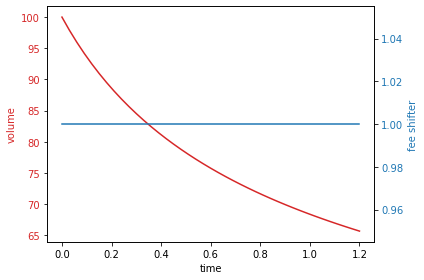

Gain is 5.671076
[0.00022885 0.00083548 0.0001299 ]
[75.  1.]


In [7]:
for i in range(0,N_T):
        thetas[0:N_agents,i] = 0.0
        thetas[(N_agents+1):(2*N_agents+1),i] = 100.0
        
        x_vals[:,i+1] = x_vals[:,i] + drift_forward(x_vals[:,i],thetas[:,i]) * delta_t

t_span = np.linspace(0, T, N_T+1)
color = 'tab:red'
fig, ax1 = plt.subplots()
ax1.set_xlabel('time')
ax1.set_ylabel('volume', color=color)
ax1.plot(t_span, x_vals[0,:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('fee shifter', color=color)  # we already handled the x-label with ax1
ax2.plot(t_span, np.exp(x_vals[1,:]), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Gain is %f' % (calc_gain(x_vals, thetas,0)))
print(grad_in_x_of_hamiltonian(x_vals[:,0], np.zeros(3), thetas[:,0], 0))
print(grad_in_theta_of_hamiltonian(x_vals[:,0], np.ones(3), thetas[:,0], 0))

In [8]:
# Fix optimization algo parameters
rho = 0.05
sigma = 0.1 # randomization for convergence
max_iter = 2000
max_error = 0.00001
print_ctr = 200 # when to print updates

# index 0 is volume
# 1,...,N fees sliders for agents 1,...,N
# N+1,...,2N stakes for agents 1,...,N
x_vals = np.zeros([2*N_agents+1,N_T+1])
x_vals[0,0] = initial_volume
x_vals[1:(N_agents+1),0] = initial_fee_sliders
x_vals[(N_agents+1):(2*N_agents)+1,0] = initial_stakes

# thetas[0:(N-1),:] controls fee sliders, thetas[N:(2*N-1),:] controls the stakes
thetas = np.zeros([2*N_agents,N_T+1])
thetas_old = np.zeros([2*N_agents,N_T+1])

diff = 0; failed_to_converge=True

gains = np.zeros(N_agents)
gains_old = np.zeros(N_agents)
errors = np.zeros(N_agents)


In [9]:

for iter_idx in range(0,max_iter):
    if iter_idx % print_ctr == 0:
        print('Iter %d, ' % (iter_idx),end='')
    
    # Run x forwards
    for i in range(0,N_T):
        x_vals[:,i+1] = x_vals[:,i]  + drift_forward(x_vals[:,i],thetas_old[:,i]) * delta_t
    
    for agt_idx in range(0,N_agents):
        p_vals = np.zeros([3,N_T+1])
        # Run p backwards
        p_vals[:,N_T] = np.zeros(3);
        p_vals[0,N_T] = terminal_volume_utility(x_vals[0,N_T],agt_idx)
    
        for i in reversed(range(0,N_T)):
            grad_x_of_Ham = grad_in_x_of_hamiltonian(x_vals[:,i+1],p_vals[:,i+1],thetas[:,i+1], agt_idx)
            p_vals[:,i] = p_vals[:,i+1] + grad_x_of_Ham * delta_t 
    
        # Do one gradient ascent step (we are maximizing) 
        selected_thetas = [agt_idx, N_agents + agt_idx]
        random_shock = sigma * np.sqrt(rho)*np.random.normal(0,1,size=np.size(thetas[selected_thetas,0]))
        for i in range(0,N_T+1): 
            thetas[selected_thetas,i] = thetas_old[selected_thetas,i] + rho*grad_in_theta_of_hamiltonian(x_vals[:,i], p_vals[:,i], thetas_old[:,i],agt_idx)
            thetas[selected_thetas,i] = thetas[selected_thetas,i] + random_shock
        
        gains[agt_idx] = calc_gain(x_vals, thetas, agt_idx)    
        if (math.isnan(gains[agt_idx])):
            print('')
            print('FAILED; agent %d, iteration %d, diff is nan.' % (agt_idx,iter_idx))
            break
        
        errors[agt_idx] = abs(gains[agt_idx] - gains_old[agt_idx])
        if iter_idx % print_ctr == 0:
            print(' agt %d, gain %f,' % (agt_idx, gains[agt_idx]),end='')
    
    thetas_old = np.copy(thetas)
    gains_old = np.copy(gains)
    if (sum(errors) < max_error):
        print('')
        print('Converged; iteration %d, error is %f' % (iter_idx, sum(errors)))
        failed_to_converge = False
        print(gains)
        print(gains_old)
        break 
                    
    
    if iter_idx % print_ctr == 0:
        print('')
        
if failed_to_converge:
    print('Failed after %d iteration, diff is %f' % (max_iter, sum(errors)))

Iter 0,  agt 0, gain 6.118841, agt 1, gain 5.962580, agt 2, gain 5.150669,
Iter 200,  agt 0, gain 5.778760, agt 1, gain 5.279575, agt 2, gain 4.011904,
Iter 400,  agt 0, gain 5.521823, agt 1, gain 4.841850, agt 2, gain 3.660547,
Iter 600,  agt 0, gain 5.475335, agt 1, gain 4.667747, agt 2, gain 3.693685,
Iter 800,  agt 0, gain 5.384517, agt 1, gain 4.443812, agt 2, gain 3.619283,
Iter 1000,  agt 0, gain 5.352830, agt 1, gain 4.358006, agt 2, gain 3.700328,
Iter 1200,  agt 0, gain 5.304772, agt 1, gain 4.228923, agt 2, gain 3.809983,
Iter 1400,  agt 0, gain 5.099696, agt 1, gain 3.893303, agt 2, gain 3.572415,
Iter 1600,  agt 0, gain 5.019424, agt 1, gain 3.826438, agt 2, gain 3.588053,
Iter 1800,  agt 0, gain 4.986732, agt 1, gain 3.722573, agt 2, gain 3.637532,
Failed after 2000 iteration, diff is 0.125529


Min fee 21.538417, Max fee 80.755532, Average fee 27.140032
Agt 0 minimum stake 75.000000
Agt 1 minimum stake 50.000000
Agt 2 minimum stake 25.000000


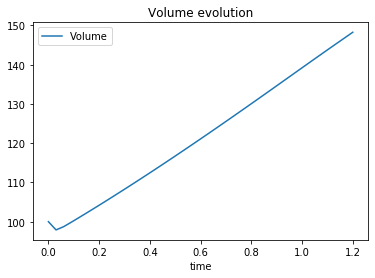

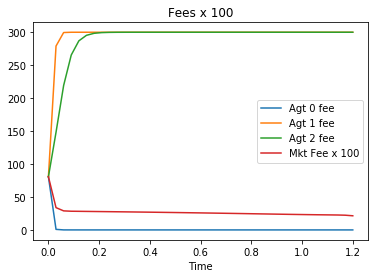

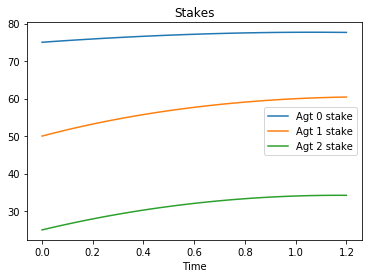

In [10]:
t_span = np.linspace(0, T, N_T+1)
plt.plot(t_span, x_vals[0,:], label='Volume')
plt.title('Volume evolution')
plt.xlabel('time')
plt.legend()

fig = plt.figure()
fees = np.zeros(N_T+1)
for i in range(0,(N_T+1)):
    fee_slider_bar = fee_slider_from_fee_sliders_and_stakes(x_vals[:,i])
    fees[i] = fee_param_logistic(fee_slider_bar)

print('Min fee %f, Max fee %f, Average fee %f' % (100*min(fees), 100*max(fees), 100*np.average(fees)))    
    
for agt_idx in range(0, N_agents):
    label_txt = 'Agt %d fee' % agt_idx
    plt.plot(t_span, 100*fee_param_logistic(x_vals[1+agt_idx,:]), label=label_txt)

plt.plot(t_span, 100*fees, label='Mkt Fee x 100')    
plt.title('Fees x 100')
plt.xlabel('Time')
plt.legend()
plt.savefig('fees_evolution_1.pdf')


fig = plt.figure()

for agt_idx in range(0, N_agents):
    label_txt = 'Agt %d stake' % agt_idx
    plt.plot(t_span, x_vals[1+N_agents+agt_idx,:], label=label_txt)
    print('Agt %d minimum stake %f' % (agt_idx, min(x_vals[1+N_agents+agt_idx,:])  ))


plt.title('Stakes')
plt.xlabel('Time')
plt.legend()
plt.savefig('stakes_evolution_1.pdf')